In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [3]:
train = train.drop("id",axis=1)
test = test.drop("id",axis=1)

In [4]:
features = ['breath_id']

In [5]:
train_X = train.drop(["pressure"],axis=1)
train_Y = train["pressure"]

In [6]:
train_X, X_valid, train_Y, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

In [7]:
lgb_train = lgb.Dataset(train_X, train_Y, categorical_feature=features)
lgb_eval = lgb.Dataset(X_valid, y_valid,  categorical_feature=features, reference=lgb_train)

In [8]:
lgbopt_train = lgbopt.Dataset(train_X, train_Y, categorical_feature=features)
lgbopt_eval = lgbopt.Dataset(X_valid, y_valid,  categorical_feature=features, reference=lgb_train)

In [9]:
params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    "boosting_type": "gbdt",
    'verbose': -1
}

In [10]:
# model_lgb = lgbopt.train(params, lgbopt_train, valid_sets=lgbopt_eval,
#                     verbose_eval=False,
#                     num_boost_round=100,
#                     early_stopping_rounds=20,
# #                     best_params=best_params,
# #                     tuning_history=history
#                         )

In [11]:
# lgbm_params = model_lgb.params
lgbm_params = {'objective': 'regression_l1',
 'metric': 'l1',
 'boosting_type': 'gbdt',
 'verbose': -1,
 'feature_pre_filter': False,
 'lambda_l1': 7.445259359815329,
 'lambda_l2': 2.78341936667752e-08,
 'num_leaves': 256,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 100,
 'early_stopping_round': 20,
 'categorical_column': [0]}

In [12]:
model_lgb = lgb.train(lgbm_params, 
                      lgb_train, 
                      valid_sets=lgb_eval, 
                      num_boost_round=100,
                      early_stopping_rounds=200,
                      verbose_eval=10)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l1: 2.7661
[20]	valid_0's l1: 2.21866
[30]	valid_0's l1: 2.05197
[40]	valid_0's l1: 1.97319
[50]	valid_0's l1: 1.919
[60]	valid_0's l1: 1.86866
[70]	valid_0's l1: 1.80507
[80]	valid_0's l1: 1.76816
[90]	valid_0's l1: 1.75207
[100]	valid_0's l1: 1.73449
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.73449


<AxesSubplot:>

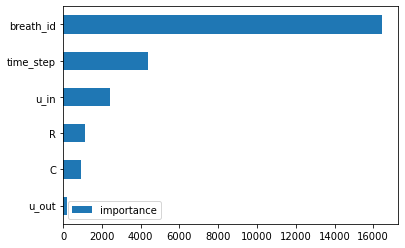

In [13]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=train_X.columns, columns=["importance"]).sort_values(by="importance",ascending =True)
importance.plot.barh()

In [14]:
folds = 2
kf = KFold(n_splits=folds)

In [15]:
models = []

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=features)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=features, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=1000,
                          early_stopping_rounds=200,
                          verbose_eval=10,
                         )
    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(np.sqrt(mean_squared_error(y_valid, y_pred)))
    
    models.append(model_lgb)    

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l1: 2.78822
[20]	valid_0's l1: 2.2419
[30]	valid_0's l1: 2.08348
[40]	valid_0's l1: 2.00702
[50]	valid_0's l1: 1.9556
[60]	valid_0's l1: 1.92361
[70]	valid_0's l1: 1.87185
[80]	valid_0's l1: 1.8341
[90]	valid_0's l1: 1.81842
[100]	valid_0's l1: 1.80794
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.80794
3.792721607591015
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l1: 2.78998
[20]	valid_0's l1: 2.23897
[30]	valid_0's l1: 2.07909
[40]	valid_0's l1: 1.99643
[50]	valid_0's l1: 1.93993
[60]	valid_0's l1: 1.87836
[70]	valid_0's l1: 1.84923
[80]	valid_0's l1: 1.83637
[90]	valid_0's l1: 1.82267
[100]	valid_0's l1: 1.81019
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.81019
3.8037616130061105


In [16]:
preds = []

for model in models:
    pred = model.predict(test)
    preds.append(pred)

In [17]:
preds_array = np.array(preds)
# preds_array = np.expm1(preds_array)
preds_array = np.clip(preds_array, 0, None)
preds_mean = np.mean(preds_array, axis=0)

In [18]:
preds_array

array([[6.37529911, 6.06184253, 7.27961706, ..., 6.18763973, 6.16357101,
        6.19425427],
       [6.37015737, 6.12463517, 7.32818161, ..., 6.17675505, 6.16243882,
        6.18869492]])

In [19]:
submission

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


In [20]:
submission['pressure'] = preds_mean

In [21]:
submission

,id,pressure
0,1,6.372728
1,2,6.093239
2,3,7.303899
3,4,8.554611
4,5,10.378331
...,...,...
4023995,4023996,6.155483
4023996,4023997,6.180928
4023997,4023998,6.182197
4023998,4023999,6.163005


In [22]:
submission.to_csv("pressure_submission.csv",index=False)